<a href="https://colab.research.google.com/github/chris-creditdesign/Chartbuilder/blob/master/topics_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.read_csv("/content/2024-04-09-NIH Grant Terminations_ Auto-Generated - grant_data.csv")

# Drop any rows where the 'cancellation_source' column is not 'HHS reported' or 'Self reported'
df_confirmed = df[df['cancellation_source'].isin(['HHS reported', 'Self reported', 'Self and HHS reported'])]
total_grants_count = len(df_confirmed)
print(f"There are {total_grants_count} rows in the dataframe.")

There are 775 rows in the dataframe.


In [2]:
df_airtable = pd.read_csv("/content/2024-04-09-nih_terminations_airtable.csv")
total_airtable_count = len(df_airtable)
print(f"There are {total_airtable_count} rows in the Airtable dataframe.")

There are 772 rows in the Airtable dataframe.


In [3]:
trans_filter_terms = [
    'affirming care',
    'assigned at birth',
    'assigned male at birth',
    'assigned female at birth',
    'gender diversity',
    'gender identity',
    'gender affirming care',
    'non-binary',
    'nonbinary',
    'transgender'
]

In [4]:
covid_filter_terms = ['COVID-19', 'SARS-CoV-2', 'COVID']

In [5]:
hiv_filter_terms = ['HIV', 'AIDS']

In [6]:
climate_filter_terms = ['Climate', 'environmental justice']

In [7]:
# Create a dict containing each collection of filter terms as a regex
# Wrap each phrase with a word boundry - to require matching of the whole phrase
# Join each term with an "or" opperator
filters = {
    "Trans Health Related": r'|'.join([r'\b' + term + r'\b' for term in trans_filter_terms]),
    "COVID-19 Related": r'|'.join([r'\b' + term + r'\b' for term in covid_filter_terms]),
    "HIV Related": r'|'.join([r'\b' + term + r'\b' for term in hiv_filter_terms]),
    "Climate related": r'|'.join([r'\b' + term + r'\b' for term in climate_filter_terms])
}

## Count the grants by filter term

In [8]:
data = []

for filter in filters.items():
  # Create a boolean mask indicating whether each row's 'terms' string contains any of the filter terms.
  terms_mask = df_confirmed['terms'].str.contains(filter[1], case=False, regex=True, na=False)

  # Create a boolean mask indicating whether each row's 'project_title' or 'abstract_text' column contains any of the filter terms.
  title_abstract_mask = df_confirmed['project_title'].str.contains(filter[1], case=False, regex=True, na=False) | \
        df_confirmed['abstract_text'].str.contains(filter[1], case=False, regex=True, na=False)

  # Filter the dataframe using the mask and count the number of entries
  terms_filtered_count = len(df_confirmed[terms_mask])
  title_abstract_filtered_count = len(df_confirmed[title_abstract_mask])

  terms_percentage = round((terms_filtered_count / total_grants_count) * 100)
  title_abstract_percentage = round((title_abstract_filtered_count / total_grants_count) * 100)

  # Append a dictionary for the current term to the list
  data.append({
      'field_of_study': filter[0],
      'terms_filtered_count': terms_filtered_count,
      'terms_percentage': terms_percentage,
      'title_abstract_filtered_count': title_abstract_filtered_count,
      'title_abstract_percentage': title_abstract_percentage
  })

  # Print some info.
  print(filter[0])
  print(f"* Terms: {terms_filtered_count} ({terms_percentage}%)")
  print(f"* Title or abstract: {title_abstract_filtered_count} ({title_abstract_percentage}%)")
  print("\n")

Trans Health Related
* Terms: 258 (33%)
* Title or abstract: 188 (24%)


COVID-19 Related
* Terms: 160 (21%)
* Title or abstract: 132 (17%)


HIV Related
* Terms: 243 (31%)
* Title or abstract: 222 (29%)


Climate related
* Terms: 37 (5%)
* Title or abstract: 28 (4%)




In [9]:
# Create a Pandas DataFrame from the data list
data_df = pd.DataFrame(data).set_index('field_of_study')

In [10]:
data_df.head()

,terms_filtered_count,terms_percentage,title_abstract_filtered_count,title_abstract_percentage
field_of_study,,,,
Trans Health Related,258,33,188,24
COVID-19 Related,160,21,132,17
HIV Related,243,31,222,29
Climate related,37,5,28,4


In [11]:
data_df.to_csv("/content/percent_words_within_title_abstract.csv")

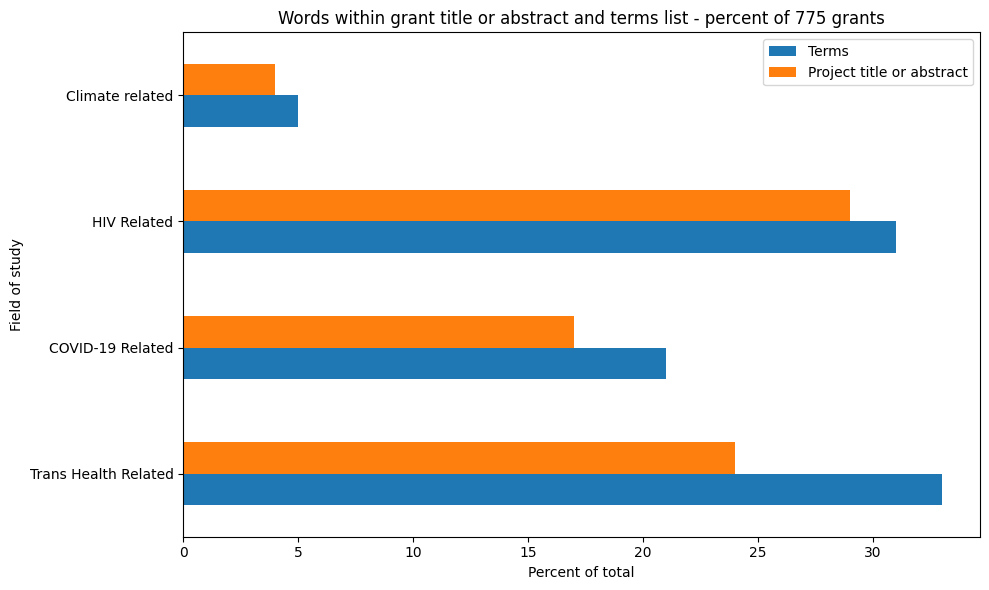

In [12]:
data_df[['terms_percentage', 'title_abstract_percentage']].plot(kind='barh', figsize=(10, 6))

# Customize the plot
plt.xlabel('Percent of total')
plt.ylabel('Field of study')
plt.title(f"Words within grant title or abstract and terms list - percent of {total_grants_count} grants")
plt.legend(['Terms', 'Project title or abstract'])
plt.tight_layout()
plt.show()